error doubling time = 0.45 , error doubling steps =  90.0


Text(0.5, 0.92, 'observation')

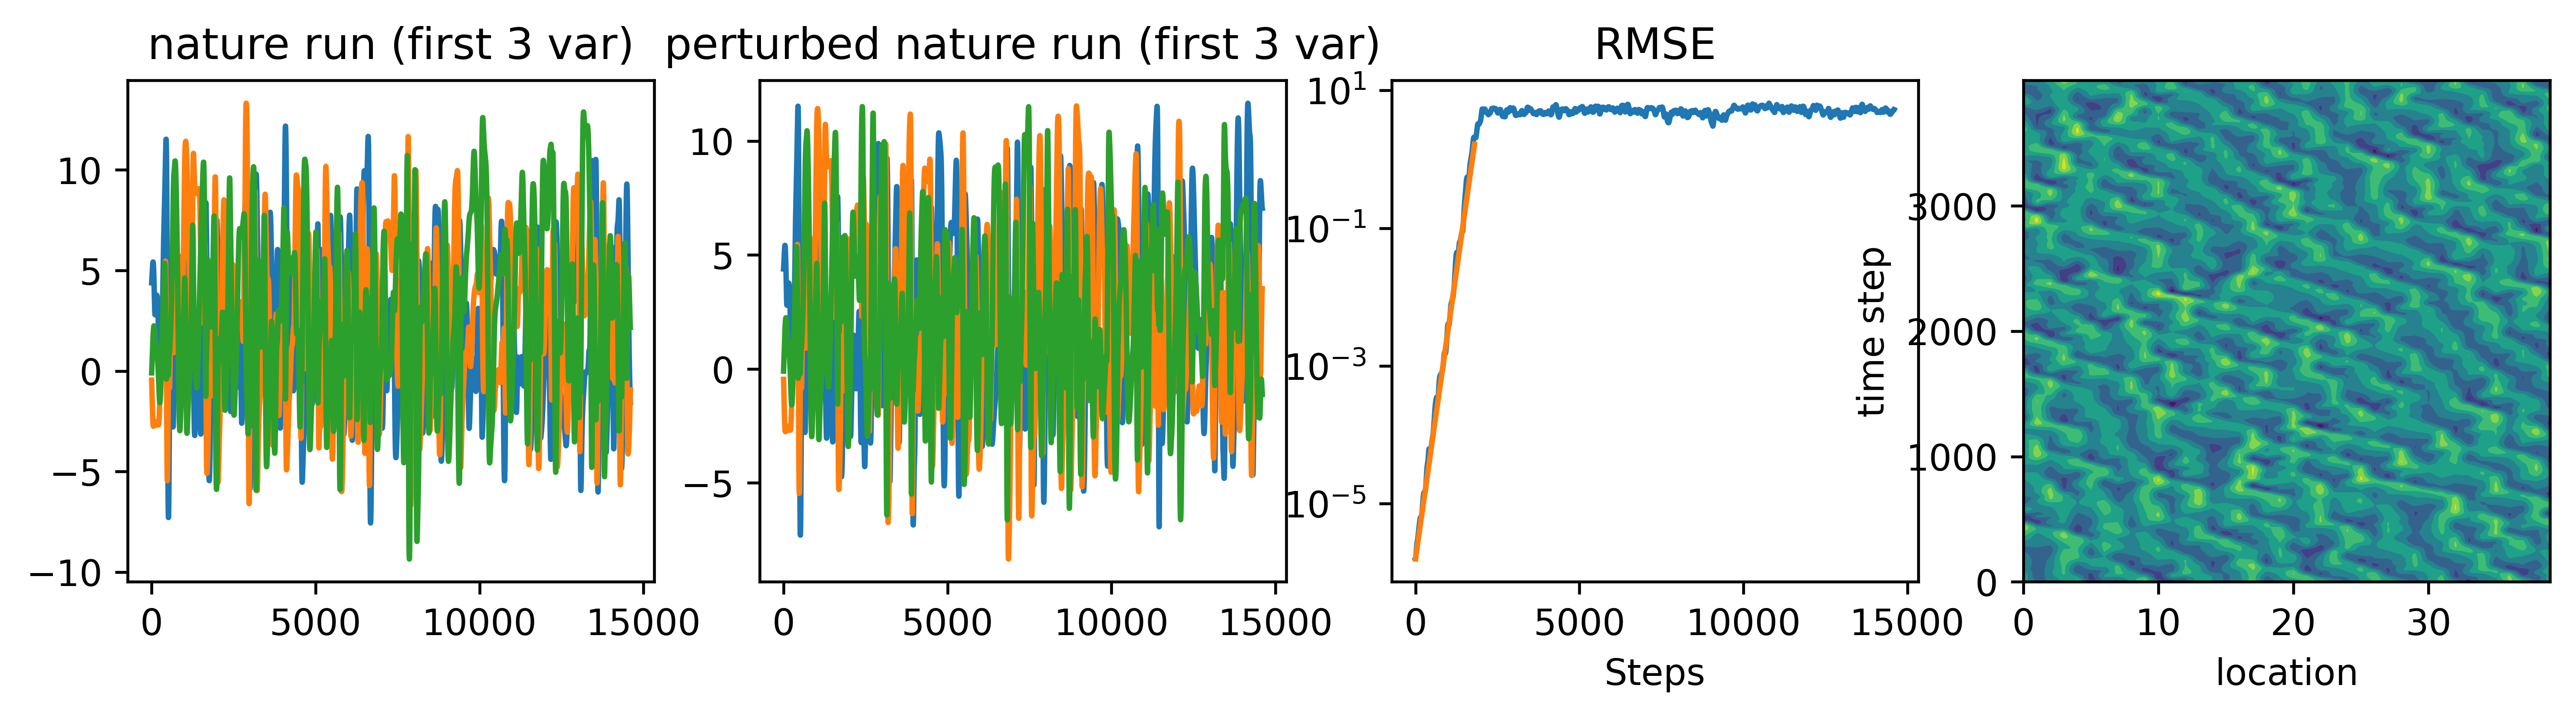

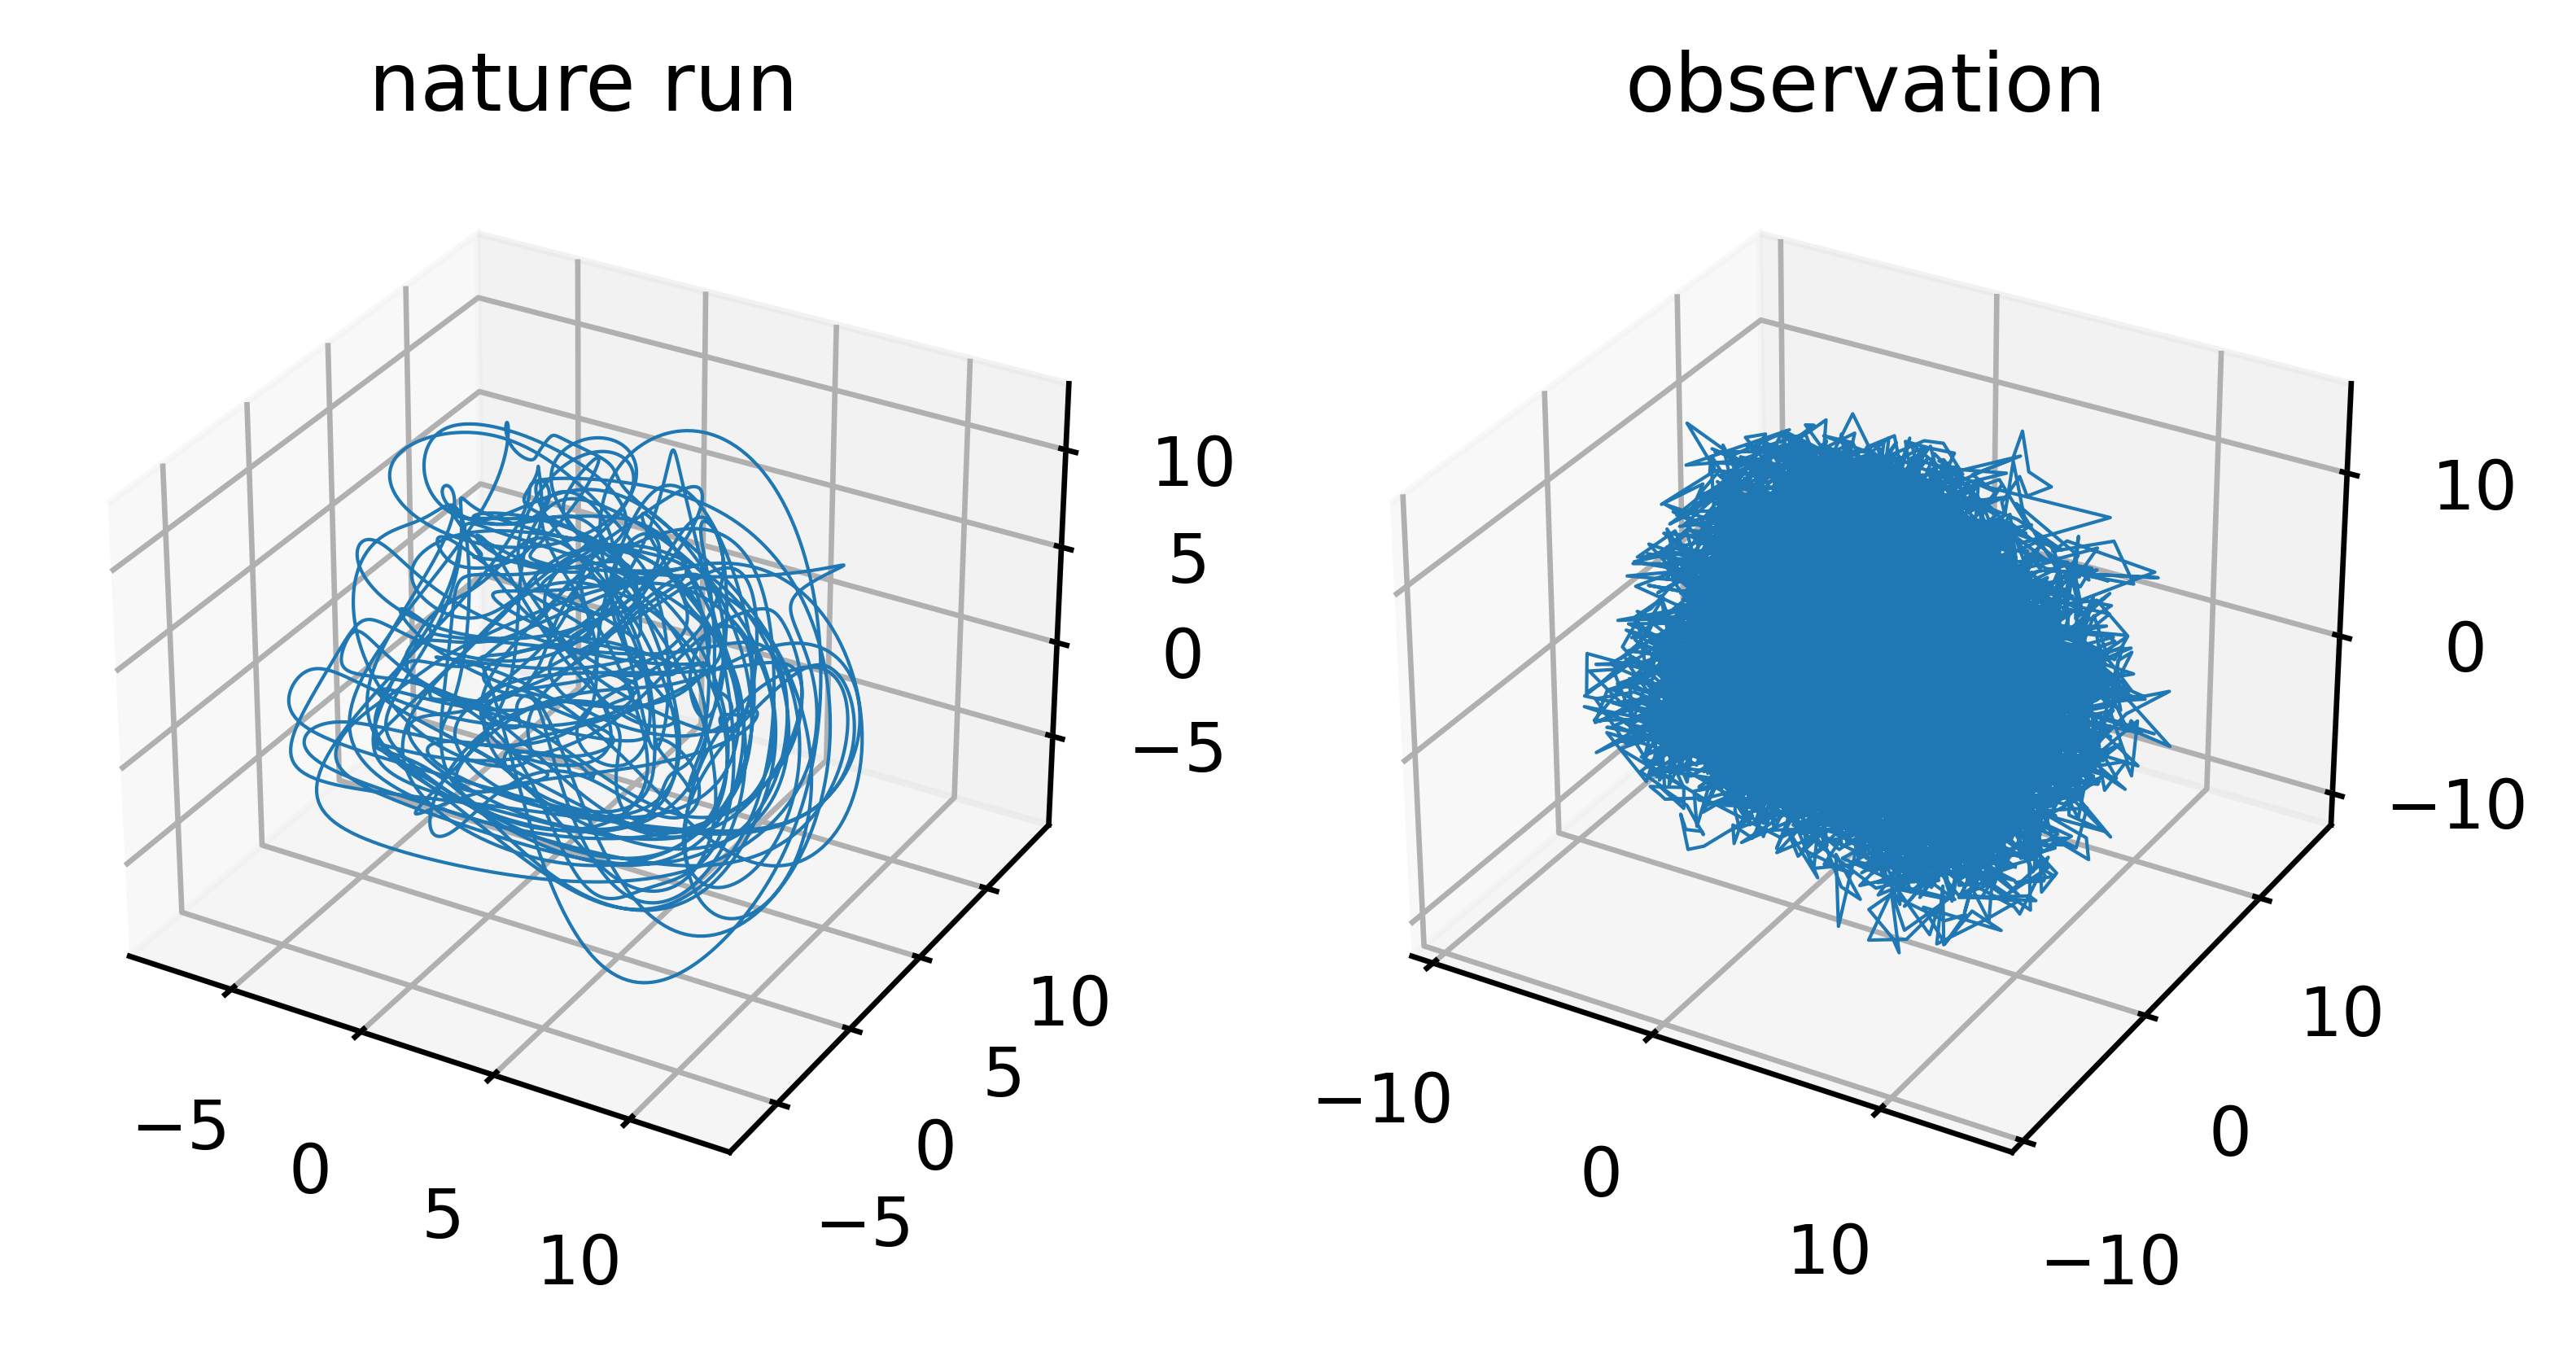

In [1]:
#%matplotlib notebook
import math                              # 数学ライブラリ
import numpy as np                       # 数値計算用の配列
import numpy.linalg as LA                # 行列計算ライブラリ
import matplotlib.pyplot as plt          # 可視化ライブラリ
from scipy.linalg import sqrtm
from matplotlib.pyplot import figure

## Runge-Kutta 4th order (removed t for simplicity)
f = 8; dt = 0.005;  n = 40; 
def x_a_dot(x_a):
    return (np.roll(x_a,-1)-np.roll(x_a,2))*np.roll(x_a,1) - x_a +f 
def lorenz96_step(x_a):     # RK 4th order. By default, no need to provide time info (because there is no t in the right hand side)
    k1 = x_a_dot(x_a)
    k2 = x_a_dot((x_a + 0.5*k1*dt))
    k3 = x_a_dot((x_a + 0.5*k2*dt))
    k4 = x_a_dot((x_a + k3*dt))
    return np.array(x_a+ (dt*(k1 + 2*k2 + 2*k3 + k4) / 6))


# note: dt = 0.05 --> 6 hours.    0.2 corresponds to 1 day. 

# Create observations: add perturbation onto nature run
# Step 1: create nature run (virtual truth)
n_steps = int(0.05*4*365/dt)  # 0.05 corresponds to 6 hours;   this is 1 year
nature = []
#x0_ = np.array(np.random.randn(n), dtype=np.float64)
#x0_ = np.array([-7.14515282e-01,  2.18901382e+00,  8.96410450e+00,  6.17594705e+00,       -2.72968500e+00, -2.98115211e+00, -3.09979742e-03,  4.60571996e+00,        3.59366294e+00,  3.81990545e+00,  4.77793655e+00, -2.76459717e+00,       -3.51057287e+00,  1.83922796e+00,  4.87497716e+00,  7.33165469e+00,        6.17024328e+00, -1.27681135e+00,  2.55693455e+00, -1.25531837e+00,        7.21313753e-01,  1.93019534e+00,  6.90871427e+00,  2.44531533e+00,       -2.50672372e+00,  3.22264341e+00,  7.52272313e+00, -4.96987962e-01,       -3.47440106e+00,  2.66745601e-01,  3.50690401e+00,  7.27108171e+00,        6.25627245e+00,  5.70534082e+00,  4.39655844e+00,  2.14429329e+00,        6.01607938e+00,  4.96662391e+00, -1.73948248e+00,  2.41560143e+00])
x0_ = np.array([ 4.36253637, -0.39362842, -0.13828232,  3.17224882,  7.16918643,       -3.02215102, -3.06938876,  0.05076294,  4.18287342,  9.56723167,        1.93034565, -4.82872617,  1.02391862,  4.10644605,  2.86953981,       -1.04191281,  1.79592455,  8.25458695, -3.00043407,  0.18839328,        2.8703275 ,  6.32154404,  5.09453683,  3.91290526, -1.09680214,        3.21094897,  4.72324689,  5.24470715,  3.7245094 , -1.82359907,        3.47226625,  5.86903124,  3.79332214, -3.95956769,  0.32428565,       -0.82539186,  9.8833754 ,  5.89827454, -0.57415782,  4.65951844])

x0 = x0_
for _ in range(n_steps):
    x0 = lorenz96_step(x0)
    nature.append(x0)

nature = np.array(nature)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4); fig.dpi=600; fig.set_size_inches(12, 2.5)
ax1.plot(nature[:,0:3]); ax1.set_title('nature run (first 3 var)')

# Step 2: how does error grow?
nature_perturbed = []
x0 = x0_
x0[30] += 0.00001
for _ in range(n_steps):
    x0 = lorenz96_step(x0)
    nature_perturbed.append(x0)
nature_perturbed = np.array(nature_perturbed)
ax2.plot(nature_perturbed[:,0:3]);ax2.set_title('perturbed nature run (first 3 var)')
diff = nature - nature_perturbed; rmse = np.sqrt(np.sum(diff*diff,1)/n)
ax3.plot( rmse); ax3.set_yscale('log'); ax3.set_xlabel('Steps'); ax3.set_title('RMSE');#ax3.set_xlim([0, 6]); ax3.set_ylim([1e-6, 1]); ax3.grid('True')
#ax3.plot(np.linspace(0,len(rmse)*dt,len(rmse)), rmse); ax3.set_yscale('log'); ax3.set_xlabel('model time'); ax3.set_title('RMSE');#ax3.set_xlim([0, 6]); ax3.set_ylim([1e-6, 1]); ax3.grid('True')

# calculate error doubling time
#Lorenz63    error doubling time is 0.75  (~ 75 steps, dt = 0.01); so DA interval should be around 75/8 ~ 10 steps
#Lorenz96    error doubling time is 0.45  (~ 90 steps, dt = 0.005); so DA interval should be around 90/8 ~ 10 steps              
errorDoublingTime = 0.27;  #errorDoublingTime = 0.60; 
errorDoublingTime = 0.45; 
time = np.linspace(0,errorDoublingTime*20,100)
error = rmse[0] * 2**(time/errorDoublingTime)
ax3.plot(time/dt,error)
print('error doubling time =',errorDoublingTime,', error doubling steps = ', errorDoublingTime/dt)


ax4.contourf(nature[0:(40 * 100), :])
ax4.set_xlabel('location')
ax4.set_ylabel('time step')




# Step 3: create observations: add perturbation to nature run
np.random.seed(10)
obs_err_std = np.sqrt(1);   obs = nature + np.random.randn(nature.shape[0], nature.shape[1]) * obs_err_std
fig = plt.figure(figsize=plt.figaspect(0.5)); fig.dpi=600; #fig.set_size_inches(12, 2.5)
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot(nature[:,0], nature[:,1], nature[:,2], lw=0.5)
ax1.set_title('nature run')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot(obs[:,0], obs[:,1], obs[:,2], lw=0.5)
ax2.set_title('observation')

# dt = 5 ~~ 6 order,  


In [2]:
def lorenz96_forecast(ensemble,ensemble_mean_history,x_history,x_mean_history):
    
    for jj in range(analysis_intv):
        for ii in range(m):
            ensemble[ii] = lorenz96_step(ensemble[ii])
        #ensemble_history.append(ensemble) # append not working for 3d
        xxx = np.array(ensemble); xxx = xxx[:,0]; x_history.append(xxx); x_mean_history.append(np.mean(xxx))
        ensemble_mean_history.append(np.mean(ensemble,axis = 0))
    
    ensemble_mean = np.mean(ensemble,axis = 0)
    ensemble_perturbed = []
    for ii in range(m):
        ensemble_perturbed.append(ensemble[ii]-ensemble_mean)
        
    Z = np.zeros((n,m))
    for ii in range(m):
        Z[:,ii] = ensemble_perturbed[ii] /np.sqrt(m-1)

    return ensemble, ensemble_mean, ensemble_perturbed, ensemble_mean_history, x_history,x_mean_history, Z
    
    
def lorenz96_analysis(ensemble, ensemble_mean, H0, y0, R0):
    
    # 1. calculate Z from ensemble and ensemble mean
    ensemble_perturbed = []
    for ii in range(m):
        ensemble_perturbed.append(ensemble[ii]-ensemble_mean)
    Z = np.zeros((n,m))
    for ii in range(m):
        Z[:,ii] = ensemble_perturbed[ii] /np.sqrt(m-1)

    # 2. calculate Y0, K, K';  note R, Y are a scalar value
    Y0 = H0@Z;  #print(Y)
    K = Z@Y0.T@LA.inv(Y0 @ (Y0.T) + R0) 
    K2 = Z@Y0.T@LA.inv(np.sqrt(Y0 @ (Y0.T) + R0))@LA.inv(np.sqrt(Y0 @ (Y0.T) + R0)+ np.sqrt(R0))
    
    # 3. member -> perturbed member
    ensemble_perturbed = []
    for ii in range(m):
        ensemble_perturbed.append(ensemble[ii]-ensemble_mean)
        
    # 4. update mean
    #ensemble_mean += K@(y0 - H0@ensemble_mean) 
    temp1 = np.array(K@(y0 - H0@ensemble_mean))
    ensemble_mean += temp1.ravel()
    
    # 5. update perturbed member
    for ii in range(m):
        temp2 = np.array(K2@(- H0@ensemble_perturbed[ii]))
        ensemble_perturbed[ii] += temp2.ravel()
    
    # 6. perturbed member -> member
    ensemble =[]
    for ii in range(m):
        ensemble.append(ensemble_perturbed[ii] + ensemble_mean)
        
    return ensemble, ensemble_mean

In [115]:
# DA process
np.random.seed(10);  obs_err_std = np.sqrt(1);  obs_err = np.random.randn(nature.shape[0], nature.shape[1]) * obs_err_std; obs = nature + obs_err;
ensemble = []; ensemble_mean_history = []; ensemble_history = []; x_history=[]; x_mean_history = []
analysis_intv = int(10); H = np.identity(n); R = np.identity(n) * obs_err_std**2;
m = 50 # ensemble size

## initialization
for _ in range(m):
    initial_state = np.random.rand(n) # random number 
    for _ in range(1000):
        initial_state = lorenz96_step(initial_state)   # free run for 1000 steps
    ensemble.append(initial_state)  


## main loop
analysis_step = n_steps-8000
for ii in range((analysis_step-1) // analysis_intv):
    ensemble, ensemble_mean, ensemble_perturbed, ensemble_mean_history, x_history,x_mean_history, Z = lorenz96_forecast(ensemble,ensemble_mean_history,x_history,x_mean_history)
    y = obs[(ii+1)*analysis_intv,:]
    
    for jj in range(len(y)):
        # pick up one obs. at one time:
        y0 = y[jj]; R0 = R[jj,jj]
        # obs. operation
        H0 = np.zeros(n); H0[jj] = 1.0; H0 = np.matrix(H0)
        # update
        ensemble, ensemble_mean = lorenz96_analysis(ensemble, ensemble_mean, H0, y0, R0)
    
    ensemble_mean_history[-1] = ensemble_mean
    # inflation
    for jj in range(m):
        ensemble[jj] = ensemble_mean + (ensemble[jj]-ensemble_mean) * np.sqrt(1.03)  # optimization needed
    print("analysis ", ii) if ii % 100 == 0 else print(".", end="")
print("Done")        


analysis  0
...................................................................................................analysis  100
...................................................................................................analysis  200
...................................................................................................analysis  300
...................................................................................................analysis  400
...................................................................................................analysis  500
...................................................................................................analysis  600
..........................................................Done


length of rmse =  658 , rmse = 0.19512699788408436


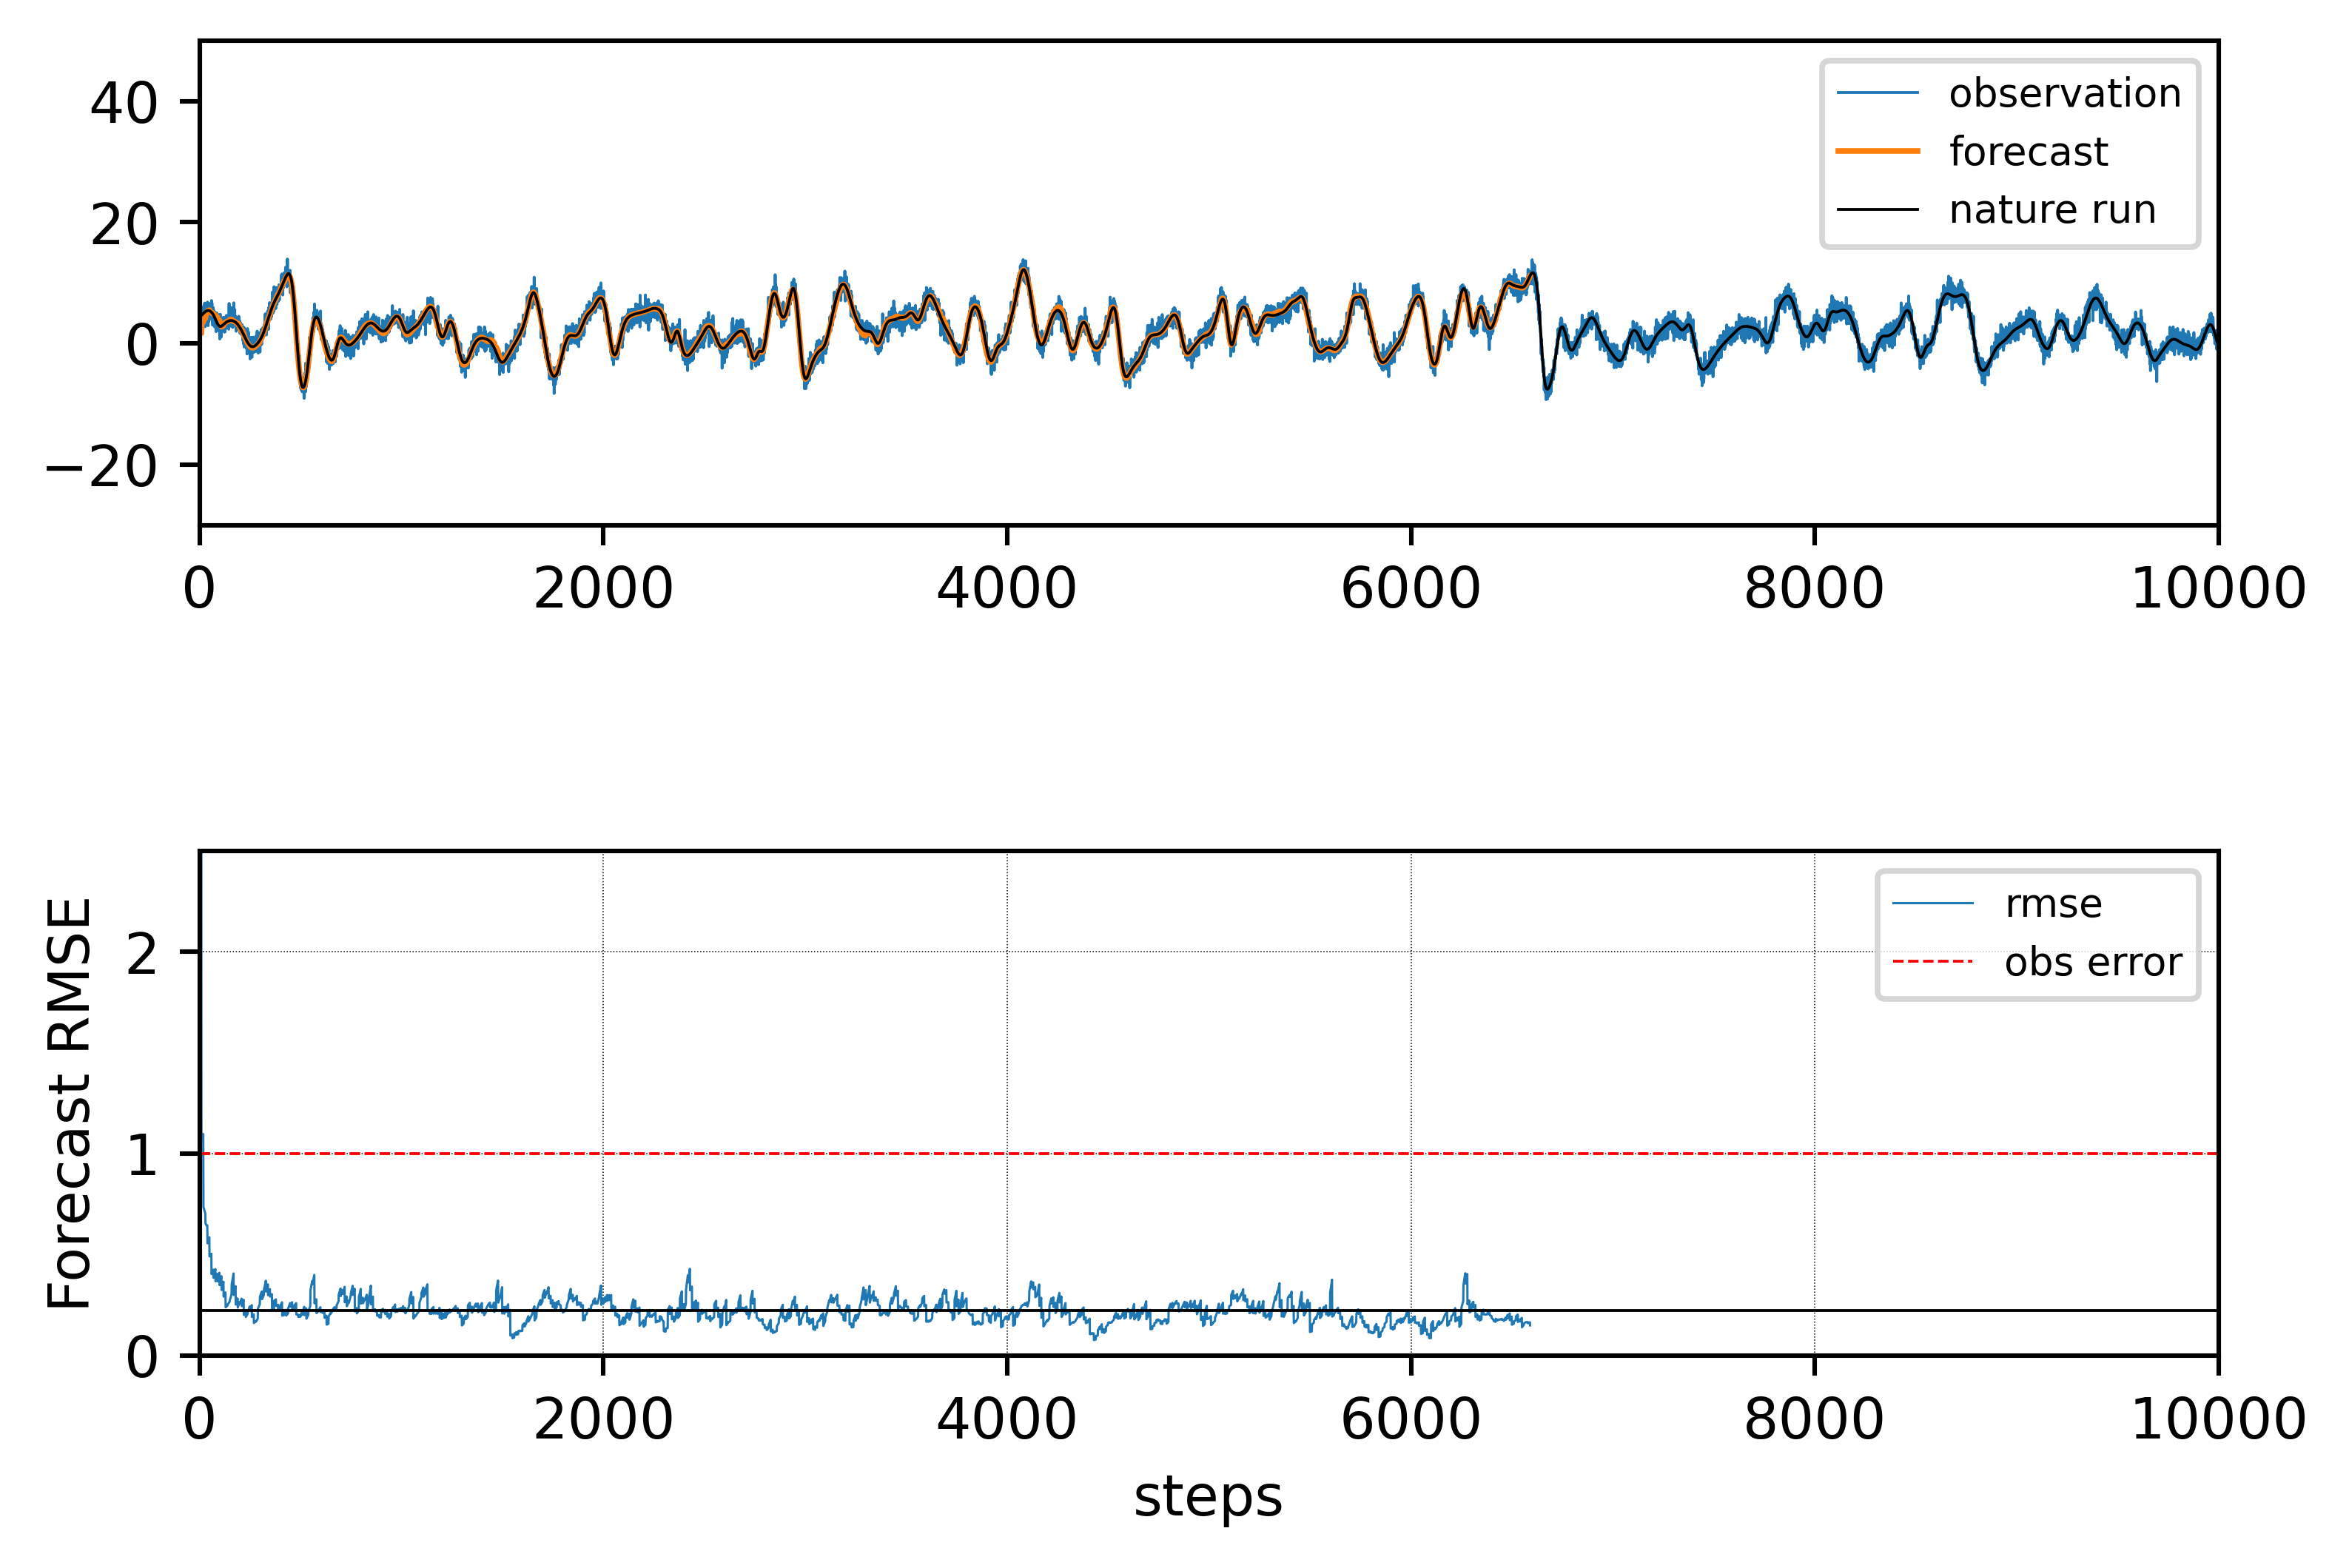

In [116]:
ensemble_mean_history = np.array(ensemble_mean_history)
ensemble_history = np.array(ensemble_history)

# plot the first variable 
fig, (ax1, ax2) = plt.subplots(2, 1);fig.dpi=550
ax1.plot(obs[:,0],label = 'observation',linewidth=0.5)
ax1.plot(x_mean_history[:],linewidth=1, label = 'forecast' )
ax1.plot(nature[:,0],label = 'nature run', color='black',linewidth=0.5)
ax1.set_aspect(30); ax1.set_xlim([0, 10000]); ax1.set_ylim([-30, 50]); ax1.legend(loc = 'upper right',fontsize = 7)

# Forecast RMSE/ Analysis RMSE
diff = ensemble_mean_history - nature[0:len(ensemble_mean_history[:,0]),:]
rmse_forecast = np.sqrt(np.sum(diff*diff,1)/n)
rmse_analysis = rmse_forecast[analysis_intv+9::analysis_intv,]
#print('length of rmse = ',len(rmse_forecast), ', rmse =' ,np.mean(rmse_forecast[4000:]))
print('length of rmse = ',len(rmse_analysis), ', rmse =' ,np.mean(rmse_analysis[400:]))

ax2.set_aspect(1000); ax2.set_xlim([0, 10000]);ax2.set_ylim([0., 2.5]); ax2.grid(True, color='black', linestyle=':', linewidth=0.2); ax2.set_xlabel('steps'); ax2.set_ylabel('Forecast RMSE')
ax2.plot(np.linspace(0,len(ensemble_mean_history[:,0]),len(rmse_forecast)),rmse_forecast,linestyle='-',marker =',',markersize = 0.1,linewidth=0.4)
ax2.axhline(y=obs_err_std, color='r', linestyle='--',linewidth=0.5); ax2.axhline(y=0, color='black', linestyle='-',linewidth=0.5); ax2.axhline(y=0.224, color='black', linestyle='-',linewidth=0.5)
ax2.legend(['rmse','obs error'],loc = 'upper right',fontsize = 7); 